In [1]:
import argparse
import numpy as np
import os
import torch
import tifffile as tiff

from video_depth_anything.video_depth import VideoDepthAnything
from utils.dc_utils import read_video_frames, save_video
from torchinfo import summary
from torchvision.transforms import Compose
from video_depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
import cv2
from thop import profile
import torch.profiler as profiler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops import rearrange
import imageio
from natsort import natsorted
import subprocess
import warnings
import re
from utils.dc_utils import read_video_frames
from utils.util import compute_scale_and_shift
from utils.align import DepthMap, frame_align_lstsq

from video_depth_anything.video_depth import INFER_LEN

In [2]:
# Load videos gt and get rgb paths: 
root_dir = '/export/data/ffeiden/data/vkitti_videos'
cam = 'Camera_0'
device = 'cuda:0'
encoder = 'vits' # Alternative 'vitl'
generate = False
SCENE = ['Scene01']#, 'Scene02', 'Scene06', 'Scene18', 'Scene20']
FPS = 25
context_length = 32
align = False
keyframes = ['0', '12']
keyframes_name = ''


for key_num in keyframes:
    keyframes_name += key_num + ','

if align:
    align_name = '_align'
else:
    align_name = ''

Name = f'SingleImage_{encoder}_con_{context_length}_{align_name}_keyframes_{keyframes}'
if os.path.exists(os.path.join(root_dir, Name)):
    gen_root_dir = os.path.join(root_dir, Name)
    if generate:
        warnings.warn('WARNING: You are about to overwrite allready generated Results.')
else:
    os.mkdir(os.path.join(root_dir, Name))
    gen_root_dir = os.path.join(root_dir, Name)

vis_methods = ['VDA_s_vits']#, 'VDA_vits', 'DepthAny2_raw', 'DepthAny2']

gt_all_data = os.listdir(os.path.join(root_dir, 'gt_vids'))

# Sort Data
methods = ['DepthAny', 'DepthAny2', 'PrimeDepth']
path_dic = {}
path_dic['gt'] = natsorted([os.path.join(root_dir, 'gt_vids', p) for p in gt_all_data if cam+'_gt'+'.tiff' in p])
for key in methods:
    path_dic[key] = natsorted([os.path.join(root_dir, 'gt_vids', p) for p in gt_all_data if key+'_' in p and cam+'.tiff' in p])
    path_dic[key+'_raw'] = natsorted([os.path.join(root_dir, 'gt_vids', p) for p in gt_all_data if key+'_' in p and cam+'_raw.tiff' in p])

path_dic['rgb'] = [p.replace('_gt.tiff', '.mp4') for p in path_dic['gt']]

_, HEIGHT, WIDTH = tiff.imread(path_dic['gt'][0]).shape

In [3]:

if generate:
    # Generate DepthAnythingVideo predictions with supprocess and save them in data 
    for video_path in path_dic['rgb']:
        if align:
            subprocess.run(["python", "run.py", "--device", device, 
                            "--input_video", os.path.join(root_dir, 'gt_vids', video_path),
                            "--output_dir", gen_root_dir,
                            "--save_tiff", 
                            "--save_vis",
                            "--save_stats",
                            "--encoder", encoder,
                            "--keyframe_list", *keyframes,
                            "--align_each_new_frame",
                            "--process_single_image",
                            "--inference_length", str(context_length)])
        else:
            subprocess.run(["python", "run.py", "--device", device, 
                            "--input_video", os.path.join(root_dir, 'gt_vids', video_path),
                            "--output_dir", gen_root_dir,
                            "--save_tiff", 
                            "--save_vis",
                            "--save_stats",
                            "--encoder", encoder,
                            "--keyframe_list", *keyframes,
                            "--process_single_image",
                            "--inference_length", str(context_length)])
        
        subprocess.run(["python", "run.py", "--device", device, 
                        "--input_video", os.path.join(root_dir, 'gt_vids', video_path),
                        "--output_dir", gen_root_dir,
                        "--save_tiff", 
                        "--save_vis",
                        "--save_stats",
                        "--encoder", encoder,])

In [4]:
# Update Paths:
gen_all_data = os.listdir(gen_root_dir)

path_dic[f'VDA_s_{encoder}'] = natsorted([os.path.join(gen_root_dir, p) for p in gen_all_data if 'Single_VideoDepthAny_' in p and '_depths.tiff' in p])
if len(path_dic[f'VDA_s_{encoder}']) == 0:
    warnings.warn('No VideoDepthAny with single image processing found, removed from list', UserWarning)
    del path_dic[f'VDA_s_{encoder}']

path_dic[f'VDA_{encoder}'] = natsorted([os.path.join(gen_root_dir, p) for p in gen_all_data if 'VideoDepthAny_' in p and '_depths.tiff' in p and 'Single_' not in p])
if len(path_dic[f'VDA_{encoder}']) == 0:
    warnings.warn('No VideoDepthAny with single image processing found, removed from list', UserWarning)
    del path_dic[f'VDA_{encoder}']

In [5]:
def resize(frame_list):
    return np.array([cv2.resize(frame, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA) for frame in frame_list])

# Load data
data_dic = {}
for key in tqdm(path_dic):
    if key != 'rgb':
        for p in path_dic[key]:
            scene_pattern = re.compile(r"(Scene\d+)")
            scene = scene_pattern.search(p).group(1)
            data = np.array(tiff.imread(p))
            _, height, width = data.shape
            if height != HEIGHT or width != WIDTH:
                data = resize(data)
            data_dic[key+f'_{scene}'] = data
        
    else:
        for p in path_dic[key]:
            scene_pattern = re.compile(r"(Scene\d+)")
            scene = scene_pattern.search(p).group(1)
            data, _ = read_video_frames(p, process_length=-1, target_fps=-1, max_res=-1)
            _, height, width, _ = data.shape
            if height != HEIGHT or width != WIDTH:
                data = resize(data)
            data_dic[key+f'_{scene}'] = data

100%|██████████| 10/10 [04:30<00:00, 27.06s/it]


In [6]:
for key in data_dic: 
    if '_raw' in key or 'VDA_' in key:
        scene_pattern = re.compile(r"(Scene\d+)")
        scene = scene_pattern.search(key).group(1)
        # We only align on the first frame for now!
        if 'VDA_s_' in key:
            prediction = data_dic[key][0]
            warm_up = len(data_dic[f'gt_{scene}']) - len(data_dic[key])
            ground_truth = data_dic[f'gt_{scene}'][warm_up]
        else:
            prediction = data_dic[key][0]
            ground_truth = data_dic[f'gt_{scene}'][0]
        
        valid_depth = ground_truth < 80.
        gt_mask = np.ma.array(ground_truth, mask=~valid_depth)
        prediction_mask = np.ma.array(prediction)
        # Raw predictions (have to be) are always inverse depth
        prediction_tmp = DepthMap(prediction_mask, inverse=True, range=None, scale=None, shift=None)
        gt_depth_tmp = DepthMap(gt_mask, inverse=False, range=None, scale=1, shift=0)
        # Calculate scale & shift for INVERSE depth
        alignment = frame_align_lstsq(prediction_tmp, gt_depth_tmp)
        scale, shift = alignment.scale, alignment.shift
        
        # Use scale & shift to align --> This is still inverse depth here!
        data_dic[key] = np.clip((data_dic[key] - shift) / scale, 0., 1.)
        
        # To make it metric we need to invert it again.
        # Avoid division by 0
        data_dic[key] = np.where( data_dic[key] == 0., 1e-4, data_dic[key]) 
        # Clip to max depth 
        data_dic[key] = np.clip(1. / data_dic[key], 0., 80.)


Assuming wamup length of 31


100%|██████████| 447/447 [01:57<00:00,  3.81it/s]


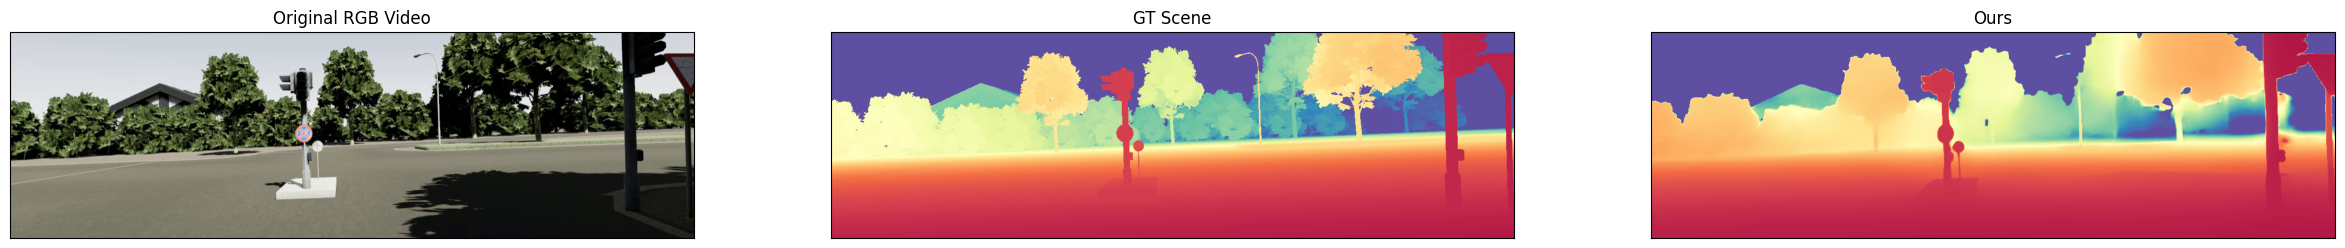

In [8]:
## Harman Results plot 

def visualise_money_plot(data_dic, root, methods= vis_methods):
        # output_name 
    vis_scene = SCENE[0]
    vis_name = f'{vis_scene}_{methods}_Money.mp4'

    # data of RGB and GT
    rgb_vid = data_dic[f'rgb_{SCENE[0]}']
    gt_depth_vid = data_dic[f'gt_{SCENE[0]}']

    # Video info 
    frame_count = len(rgb_vid)
    height = rgb_vid.shape[1]
    width = rgb_vid.shape[2]


    # Set up figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    
    # Prepare plot 
    Loss_dict = {}
    stability_over_time = {}
    depth_min, depth_max = np.inf, 0.
    error_min, error_max = np.inf, 0.
    warm_length = None

    # Calculate max
    for method in methods:
        method_pred = data_dic[method+f'_{SCENE[0]}']
        method_min, method_max = method_pred.min(), method_pred.max()
        if method_min < depth_min:
            depth_min = method_min
        if method_max > depth_max:
            depth_max = method_max

        try:
                error = np.abs(gt_depth_vid - method_pred)
        except ValueError:
            warm_length = len(gt_depth_vid) - len(method_pred)
            print(f'Assuming wamup length of {warm_length}')
            error = np.abs(gt_depth_vid[warm_length:] - method_pred)

    # Setup video writer variables
    writer = imageio.get_writer(os.path.join(root, vis_name), fps=FPS, macro_block_size=1, codec='libx264', ffmpeg_params=['-crf', '18'])
    for t in tqdm(range(len(rgb_vid))):
        # Start with GT viedo
        axs[0].clear()
        axs[0].imshow(rgb_vid[t])
        axs[0].set_title('Original RGB Video')
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        # GT depth
        axs[1].clear()
        axs[1].imshow(gt_depth_vid[t], cmap='Spectral', vmin=depth_min, vmax=depth_max)
        axs[1].set_title('GT Scene')
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        #Loss plo
        for i, method in enumerate(methods):
            if 'VDA_s_' in method and t <= warm_length:
                # Plot Frames
                method_pred = np.zeros((warm_length, HEIGHT, WIDTH))
                error_map = np.zeros((HEIGHT, WIDTH))
                # Stability over time
                t_warmup = t
            else:
                if 'VDA_s_' in method:

                    # Plot Frames
                    method_pred = data_dic[method+f'_{SCENE[0]}']
                    error_map = np.abs(gt_depth_vid[t] - method_pred[t-t_warmup])


            # Prediction
            if 'VDA_s_' in method:
                axs[2].clear()

                axs[2].imshow(method_pred[t-t_warmup], cmap='Spectral', vmin=depth_min, vmax=depth_max)

                axs[2].set_xticks([])
                axs[2].set_yticks([])
                axs[2].set_title('Ours')
            else:
                break


        fig.canvas.draw()
        matplotlib_frame = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
        writer.append_data(matplotlib_frame)
    
    writer.close()

visualise_money_plot(data_dic, '.')
    

In [ ]:
# Visualise Data
def visualise_data(data_dic, methods, scene_idx, root='.', Loss_function=None, Loss_name='None', stability_line=0.5):
    # output_name 
    vis_scene = SCENE[scene_idx]
    vis_name = f'{vis_scene}_{methods}_Vis.mp4'

    # data of RGB and GT
    rgb_vid = data_dic[f'rgb_{SCENE[scene_idx]}']
    gt_depth_vid = data_dic[f'gt_{SCENE[scene_idx]}']

    # Video info 
    frame_count = len(rgb_vid)
    height = rgb_vid.shape[1]
    width = rgb_vid.shape[2]
    stability_x_value = int(width * stability_line)

    # Set up figure
    fig, axs = plt.subplots(nrows=len(methods)+1, ncols=3, figsize=(40, 30))
    
    # Prepare plot 
    Loss_dict = {}
    stability_over_time = {}
    depth_min, depth_max = np.inf, 0.
    error_min, error_max = np.inf, 0.
    Loss_axs = axs[0, 2]
    warm_length = None
    if Loss_function is not None:
        for method in methods:
            # Calculate max
            method_pred = data_dic[method+f'_{SCENE[scene_idx]}']
            method_min, method_max = method_pred.min(), method_pred.max()
            if method_min < depth_min:
                depth_min = method_min
            if method_max > depth_max:
                depth_max = method_max

            try:
                error = np.abs(gt_depth_vid - method_pred)
            except ValueError:
                warm_length = len(gt_depth_vid) - len(method_pred)
                print(f'Assuming wamup length of {warm_length}')
                error = np.abs(gt_depth_vid[warm_length:] - method_pred)
            method_er_min, method_er_max = error.min(), error.max()
            if method_er_min < error_min:
                error_min = method_er_min
            if method_er_max > error_max:
                error_max = method_er_max

            # Calculate Loss
            if 'VDA_s_' in method:
                Loss_dict[method] = Loss_function(method_pred, gt_depth_vid[warm_length:])
            else:
                Loss_dict[method] = Loss_function(method_pred, gt_depth_vid)
            # Set up Lines
            Loss_dict[method+'_line'], = Loss_axs.plot([], [], label=method)
            # Prepare Stablity image
            stability_over_time[method] = np.zeros((height, frame_count), dtype=np.float32)
    else:
        for method in methods:
            # Calculate max
            method_pred = data_dic[method+f'_{SCENE[scene_idx]}']
            method_min, method_max = method_pred.min(), method_pred.max()
            if method_min < depth_min:
                depth_min = method_min
            if method_max > depth_max:
                depth_max = method_max

            try:
                error = np.abs(gt_depth_vid - method_pred)
            except ValueError:
                warm_length = len(gt_depth_vid) - len(method_pred)
                print(f'Assuming wamup length of {warm_length}')
                error = np.abs(gt_depth_vid[warm_length:] - method_pred)
            method_er_min, method_er_max = error.min(), error.max()
            if method_er_min < error_min:
                error_min = method_er_min
            if method_er_max > error_max:
                error_max = method_er_max
            
            # If no Loss is given we calculate MSE
            if 'VDA_s_' in method:
                Loss_dict[method] = np.mean((method_pred - gt_depth_vid[warm_length:])**2, axis=(1,2))
            else:
                Loss_dict[method] = np.mean((method_pred - gt_depth_vid)**2, axis=(1,2))
             # Set up Lines
            Loss_dict[method+'_line'], = Loss_axs.plot([], [], label=method)
            # Prepare Stablity image
            stability_over_time[method] = np.zeros((height, frame_count), dtype=np.float32)
    
    Loss_min, Loss_max = np.inf , 0.
    for key in methods:
        min_, max_ = Loss_dict[key].min(), Loss_dict[key].max()
        if min_ < Loss_min:
            Loss_min = min_
        if max_ > Loss_max:
            Loss_max = max_ 

    Loss_axs.set_xlim(0, frame_count)
    Loss_axs.set_ylim( Loss_min, Loss_max)

    # Setup video writer variables
    writer = imageio.get_writer(os.path.join(root, vis_name), fps=FPS, macro_block_size=1, codec='libx264', ffmpeg_params=['-crf', '18'])
    for t in tqdm(range(len(rgb_vid))):
        # Start with GT viedo
        axs[0, 0].clear()
        axs[0, 0].imshow(rgb_vid[t])
        axs[0, 0].set_xticks([])
        axs[0, 0].set_yticks([])
        # GT depth
        axs[0, 1].clear()
        axs[0, 1].imshow(gt_depth_vid[t], cmap='Spectral', vmin=depth_min, vmax=depth_max)
        axs[0, 1].set_title('GT Scene')
        axs[0, 1].set_xticks([])
        axs[0, 1].set_yticks([])
        #Loss plot
        axs[0, 2].legend()
        if Loss_function is None:
            axs[0, 2].set_title(f'Absolute Diff.')
        else:
            axs[0, 2].set_title(f'{Loss_name}')

        for i, method in enumerate(methods):
            if 'VDA_s_' in method and t <= warm_length:
                # Plot Frames
                method_pred = np.zeros((warm_length, HEIGHT, WIDTH))
                error_map = np.zeros((HEIGHT, WIDTH))
                # Stability over time
                satbility = stability_over_time[method]
                t_warmup = t
            else:
                if 'VDA_s_' in method:
                    Loss_dict[method+'_line'].set_data(np.arange(t-t_warmup) + t_warmup, Loss_dict[method][:t-t_warmup])

                    # Plot Frames
                    method_pred = data_dic[method+f'_{SCENE[scene_idx]}']
                    error_map = np.abs(gt_depth_vid[t] - method_pred[t-t_warmup])
                    # Stability over time
                    satbility = stability_over_time[method]
                    satbility[:, t] = method_pred[t-t_warmup, :, stability_x_value]
                    stability_over_time[method] = satbility
                else:
                    Loss_dict[method+'_line'].set_data(np.arange(t), Loss_dict[method][:t])

                    # Plot Frames
                    method_pred = data_dic[method+f'_{SCENE[scene_idx]}']
                    error_map = np.abs(gt_depth_vid[t] - method_pred[t])
                    # Stability over time
                    satbility = stability_over_time[method]
                    satbility[:, t] = method_pred[t, :, stability_x_value]
                    stability_over_time[method] = satbility
            # Abs Err. to gt
            axs[i+1, 0].clear()
            axs[i+1, 0].imshow(error_map, cmap='RdYlGn', vmin=error_min, vmax=error_max)
            axs[i+1, 0].set_xticks([])
            axs[i+1, 0].set_yticks([])
            # Prediction
            axs[i+1, 1].clear()
            if 'VDA_s_' in method:
                axs[i+1, 1].imshow(method_pred[t-t_warmup], cmap='Spectral', vmin=depth_min, vmax=depth_max)
            else:
                axs[i+1, 1].imshow(method_pred[t], cmap='Spectral', vmin=depth_min, vmax=depth_max)
            axs[i+1, 1].set_xticks([])
            axs[i+1, 1].set_yticks([])
            axs[i+1, 1].set_title(method)
            # Stability over time
            axs[i+1, 2].clear()
            axs[i+1, 2].imshow(satbility, cmap='Spectral', vmin=depth_min, vmax=depth_max)
            axs[i+1, 2].set_xticks([])
            axs[i+1, 2].set_yticks([])

        fig.canvas.draw()
        matplotlib_frame = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
        writer.append_data(matplotlib_frame)
    
    writer.close()

#TODO: Include Metric for temporal consistency 
#TODO: Include calculation of Average MSE after alignment (Also other metrics like inlier ration etc.)


In [ ]:
visualise_data(data_dic=data_dic, methods=vis_methods, scene_idx=0)

In [ ]:
visualise_data(data_dic=data_dic, methods=vis_methods, scene_idx=1)

In [ ]:
visualise_data(data_dic=data_dic, methods=vis_methods, scene_idx=2)

In [ ]:
visualise_data(data_dic=data_dic, methods=vis_methods, scene_idx=3)

In [ ]:
visualise_data(data_dic=data_dic, methods=vis_methods, scene_idx=4)

In [7]:
Metrics_dic = {}
for method in vis_methods:
    Metrics_dic[method+'_MSE'] = []
    Metrics_dic[method+'_Abs'] = []

for scene in SCENE:
    gt_depth_vid = data_dic['gt_'+scene]
    for method in vis_methods:
        method_pred = data_dic[method + '_' + scene]
        try:
            error = np.abs(gt_depth_vid - method_pred).sum() / gt_depth_vid.size
            MSE_err = np.mean((method_pred - gt_depth_vid)**2)
        except ValueError:
            warm_length = len(gt_depth_vid) - len(method_pred)
            MSE_err = np.mean((method_pred - gt_depth_vid[warm_length:])**2)
            print(f'Assuming wamup length of {warm_length}')
            error = np.abs(gt_depth_vid[warm_length:] - method_pred).sum() / gt_depth_vid.size
        
        print(f'{scene} {method}: ')
        print('-----------------------')
        print(f'Abs. Error: {error:.3f}')
        print(f'MSE Error: {MSE_err:.3f}')
        print('')
        Metrics_dic[method+'_MSE'].append(MSE_err)
        Metrics_dic[method+'_Abs'].append(error)

for method in vis_methods:
    error = np.mean(Metrics_dic[method+'_Abs'])
    MSE_err = np.mean(Metrics_dic[method+'_MSE'])


    print(f'Overall {method}: ')
    print('-----------------------')
    print(f'Abs. Error: {error:.3f}')
    print(f'MSE Error: {MSE_err:.3f}')
    print('')

Assuming wamup length of 12
Scene01 VDA_s_vits: 
-----------------------
Abs. Error: 3.625
MSE Error: 66.677

Scene01 VDA_vits: 
-----------------------
Abs. Error: 4.635
MSE Error: 84.326

Scene01 DepthAny2_raw: 
-----------------------
Abs. Error: 4.306
MSE Error: 57.205

Scene01 DepthAny2: 
-----------------------
Abs. Error: 2.402
MSE Error: 33.227

Assuming wamup length of 12
Scene02 VDA_s_vits: 
-----------------------
Abs. Error: 2.970
MSE Error: 54.797

Scene02 VDA_vits: 
-----------------------
Abs. Error: 3.205
MSE Error: 57.380

Scene02 DepthAny2_raw: 
-----------------------
Abs. Error: 5.068
MSE Error: 93.679

Scene02 DepthAny2: 
-----------------------
Abs. Error: 2.523
MSE Error: 36.432

Assuming wamup length of 12
Scene06 VDA_s_vits: 
-----------------------
Abs. Error: 2.721
MSE Error: 37.135

Scene06 VDA_vits: 
-----------------------
Abs. Error: 2.826
MSE Error: 35.753

Scene06 DepthAny2_raw: 
-----------------------
Abs. Error: 3.829
MSE Error: 51.014

Scene06 Depth

In [8]:
Name

"SingleImage_vits_con_32__align_keyframes_['0', '12']"